In [57]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate, HGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

backend = Aer.get_backend("qasm_simulator")
num_shots = 1024

N = 2
M = 1
n_anc = 2 * M

def get_hamilt_op(N, lambd):
    hlist = []
    coeffs = []
    
    for i in range(N - 1):
        text = "I" * i + "ZZ" + "I" * (N - i - 2)
        hlist.append(text)
        coeffs.append(1)

    if lambd:
        for i in range(N):
            text = "I" * i + "X" + "I" * (N - i - 1)
            hlist.append(text)
            coeffs.append(lambd)

    return SparsePauliOp(hlist, coeffs=coeffs)

### Test circuit for the ancillary qubits

        ┌───────────┐                   ░ ┌─┐   
   a_0: ┤ Ry(1.231) ├──o────────■───────░─┤M├───
        └┬─────────┬┘┌─┴─┐┌─────┴─────┐ ░ └╥┘┌─┐
   a_1: ─┤ Ry(π/2) ├─┤ X ├┤ Rz(-3π/2) ├─░──╫─┤M├
         └─────────┘ └───┘└───────────┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════╩══╩═
                                           0  1 


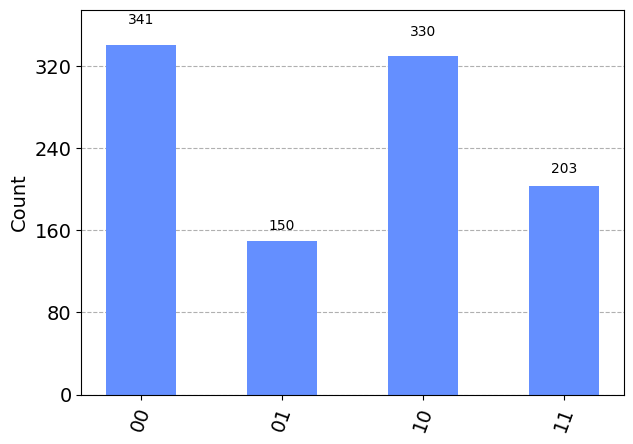

In [58]:
anc = QuantumRegister(n_anc, name="a")
syst = QuantumRegister(N, name="q")
qc = QuantumCircuit(anc)

alpha = 2 * np.arctan(np.sqrt(0.5))
beta = 0.5 * np.pi
gamma = -1.5 * np.pi

qc.ry(alpha, 0)
qc.ry(beta, 1)
qc.cx(0, 1, ctrl_state=0)
qc.crz(gamma, control_qubit=0, target_qubit=1)

qc.measure_all()
print(qc)
results = execute(qc, backend=backend, num_shots=num_shots)
counts = results.result().get_counts()

plot_histogram(counts)

### Test the complete circuit, single iteration

              ┌───────────┐                                                »
a_0: ─────────┤ Ry(1.231) ├────────────o────────■───────────────■──────────»
              └┬─────────┬┘          ┌─┴─┐┌─────┴─────┐         │          »
a_1: ──────────┤ Ry(π/2) ├───────────┤ X ├┤ Rz(-3π/2) ├─────────┼──────────»
     ┌─────────┴─────────┴──────────┐└───┘└───────────┘┌────────┴─────────┐»
q_0: ┤0                             ├──────────────────┤0                 ├»
     │  Initialize(0.5,0.5,0.5,0.5) │                  │  exp(-it ZZ)(-1) │»
q_1: ┤1                             ├──────────────────┤1                 ├»
     └──────────────────────────────┘                  └──────────────────┘»
«                        ┌───┐
«a_0: ─────────■─────────┤ H ├
«              │         ├───┤
«a_1: ─────────■─────────┤ H ├
«     ┌────────┴────────┐└───┘
«q_0: ┤0                ├─────
«     │  exp(-it ZZ)(2) │     
«q_1: ┤1                ├─────
«     └─────────────────┘     
dict_values([108, 9, 129, 5]

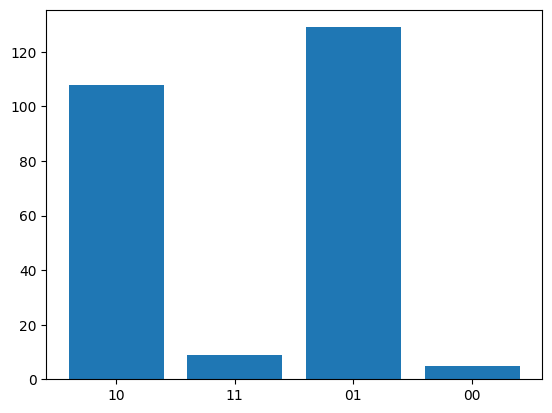

In [69]:
anc = QuantumRegister(n_anc, name="a")
syst = QuantumRegister(N, name="q")
cbits = ClassicalRegister(2, name="cbits")

cbits_flag = False
if cbits_flag:
    qc = QuantumCircuit(anc, syst, cbits)
else:
    qc = QuantumCircuit(anc, syst)

# initialize system qubits
qc.initialize([1/2, 1/2, 1/2, 1/2], [2, 3])

# setup gates for ancillary qubits
qc.ry(alpha, 0)
qc.ry(beta, 1)
qc.cx(0, 1, ctrl_state=0)
qc.crz(gamma, control_qubit=0, target_qubit=1)

# setup gates for system qubits
H = get_hamilt_op(N, 0.)
dt = 1

evo = PauliEvolutionGate(H, -dt).control(1)
qc.append(evo, [0, 2, 3]) # control on qubit 0 and act on qubits 2 and 3

evo = PauliEvolutionGate(H, 2 * dt).control(2)
qc.append(evo, [0, 1, 2, 3]) # control on qubits 0 and 1 and act on qubits 2 and 3

# setup measurement gates
qc.h([0, 1])
print(qc)

# perform measurement and collect samples of the 
# system state on the subspace |00> of the 
# ancillary system
qc.measure_all()

results = execute(qc, backend=backend, num_shots=num_shots)
counts = results.result().get_counts()

evo_state_dict = {}

for k, v in counts.items():
    pieces = list(k)

    if pieces[-1] == '0' and pieces[-2] == '0':
        k_new = pieces[0] + pieces[1]
        
        evo_state_dict[k_new] = v

states = evo_state_dict.keys()
counts = evo_state_dict.values()

print(counts)
plt.bar(states, counts);